In [1]:
!pip3 install torchmetrics
!pip3 install segmentation-models-pytorch
!pip3 install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.1 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f72e666ee0614996382de4a1de948324e4b18dd5f44e77dd1da29840c31be2d4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=3e4620a8100a14a145bc9eec7fcad5a0d03bec6b3a9fa92795cb06fa0f73daae
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built 

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor


import os
from tqdm import tqdm
from glob import glob # read and close image in folder


19 Tissue types (Breast, Colon, Bile-duct, Esophagus, Uterus, Lung, Cervix, Head&Neck, Skin, Adrenal Gland, Kidney, Stomach, Prostate, Testis, Liver, Thyroid, Pancreas, Ovary, Bladder). Note, that it also unifies existing datasets within it, we have carefully labelled these under a single nuclei categories schema that is common to all 19 tissues. 

**This particular directory includes training patches of size 256x256 and their masks, this is one of the folds. In total there are more than 7 thousand training patches within all of the three folds.**

The files within each fold directories are:

* `images.npy` - image patches of 256x256

* `masks.npy` an array of 6 channel instance-wise masks (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 6: Background)

* `types.py`  tissue type that a given path was extracted from.

In [10]:
# images_dir = "/kaggle/input/pannuke/Fold 1/images/images.npy"
# types_dir = "/kaggle/input/pannuke/Fold 1/images/types.npy"
# masks_dir = "/kaggle/input/pannuke/Fold 1/masks/masks.npy"
# images = np.load(images_dir) # 2656,256,256,3
# images = images.astype('int32')
# types = np.load(types_dir) # 2656
# masks = np.load(masks_dir) # 2656,256,256,6

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

PANNUKE_CLASSES = [
    "Neoplastic cells",
    "Inflammatory",
    "Connective",
    "Dead Cells",
    "Epithelial",
    "Background",
]


images = np.load("/kaggle/input/pannuke-cut/images.npy")
types = np.load("/kaggle/input/pannuke-cut/types.npy")
masks = np.load("/kaggle/input/pannuke-cut/masks.npy")

print(images.shape, masks.shape)

(100, 256, 256, 3) (100, 256, 256, 6)


In [11]:
# import random
# N = random.randint(0, 100)
# mask = torch.tensor(masks)
# mask = mask.argmax(dim=-1)
# # Create a mapping array
# mapping = torch.tensor([1, 2, 3, 4, 5, 0])

# # Apply the mapping
# masks = mapping[mask]
# plt.subplot(1,2,1)
# plt.imshow(images[N,:])
# plt.subplot(1,2,2)
# plt.imshow(masks[N,:])
# plt.show()

In [12]:
class PannukeDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        super().__init__()
        self.images = images
        self.masks = masks
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        # (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 5: Background)
        # -> (1: Neoplastic cells, 2: Inflammatory, 3: Connective/Soft tissue cells, 4: Dead Cells, 5: Epithelial, 0: Background)

        mask = mask.argmax(dim=-1)
        # Create a mapping array
        mapping = torch.tensor([1, 2, 3, 4, 5, 0])

        # Apply the mapping
        masks = mapping[mask]
        
        return image, mask

In [13]:
trainsize = 257
train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    # A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    # A.RGBShift(),
    A.CoarseDropout(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

class PannukeDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        super().__init__()
        self.images = images
        self.masks = masks
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image = torch.tensor(self.images[index,:])
        image = image.float()
        mask = torch.tensor(self.masks[index,:])
        
        mask = mask.argmax(dim=-1)
        # (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 5: Background)
        # -> (1: Neoplastic cells, 2: Inflammatory, 3: Connective/Soft tissue cells, 4: Dead Cells, 5: Epithelial, 0: Background)
        # Create a mapping array
        mapping = torch.tensor([1, 2, 3, 4, 5, 0])
        # Apply the mapping
        mask = mapping[mask]
        
        if self.transform is not None:
            # Convert PIL image to numpy array
            image_np = image.numpy()
            mask_np = mask.numpy()
            # Apply transformations
            transformed = self.transform(image=image_np, mask=mask_np)
            image = transformed["image"]
            mask = transformed["mask"]
        
        return image, mask

In [14]:
def tensor_to_np(tensor):
    # Make sure the tensor is on the CPU and convert to NumPy
    return tensor.detach().cpu().numpy()

def np_to_tensor(array):
    # Convert a NumPy array back to PyTorch tensor
    return torch.tensor(array).float()

def inverse_norm(image):
    # Define the inverse transformation using Albumentations
    invTrans = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225], max_pixel_value=1.0),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.], max_pixel_value=1.0),
    ])

    # Example usage:
    # Assuming 'tensor_image' is your normalized image tensor
    tensor_image_np = tensor_to_np(image)  # Convert tensor to numpy array
    tensor_image_np = np.transpose(tensor_image_np, (1, 2, 0))  # CHW to HWC for Albumentations

    # Apply the inverse transformation
    inv_img_np = invTrans(image=tensor_image_np)['image']
    inv_img_np = np.transpose(inv_img_np, (2, 0, 1))  # HWC back to CHW for PyTorch

    # Convert back to tensor
    inv_img_tensor = np_to_tensor(inv_img_np)
    return inv_img_tensor


torch.Size([3, 257, 257]) torch.Size([257, 257])
tensor([0, 1, 3], dtype=torch.int32)
tensor([[[0.7271, 0.7344, 0.7480,  ..., 0.6318, 0.6704, 0.6978],
         [0.7141, 0.7249, 0.7467,  ..., 0.6401, 0.6781, 0.7044],
         [0.6812, 0.6973, 0.7349,  ..., 0.6598, 0.6959, 0.7220],
         ...,
         [0.7587, 0.7636, 0.7728,  ..., 0.6033, 0.5918, 0.5856],
         [0.7094, 0.7233, 0.7437,  ..., 0.5958, 0.5894, 0.5853],
         [0.6954, 0.7115, 0.7357,  ..., 0.5936, 0.5882, 0.5850]],

        [[0.5359, 0.5432, 0.5550,  ..., 0.4869, 0.5223, 0.5481],
         [0.5264, 0.5360, 0.5545,  ..., 0.4953, 0.5313, 0.5586],
         [0.5008, 0.5157, 0.5519,  ..., 0.5150, 0.5482, 0.5749],
         ...,
         [0.6356, 0.6420, 0.6588,  ..., 0.4321, 0.4211, 0.4142],
         [0.5832, 0.5987, 0.6265,  ..., 0.4240, 0.4176, 0.4137],
         [0.5672, 0.5861, 0.6178,  ..., 0.4212, 0.4168, 0.4138]],

        [[0.6341, 0.6437, 0.6544,  ..., 0.5975, 0.6332, 0.6595],
         [0.6243, 0.6362, 0.6538,  ..

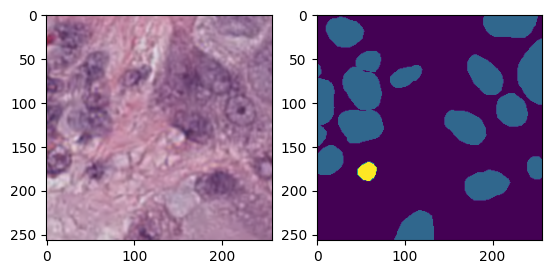

In [15]:
train_dataset = PannukeDataset(images,masks, transform=train_transform)
image,mask = train_dataset.__getitem__(10)

print(image.shape, mask.shape)
print(mask.unique())
inv_img_tensor = inverse_norm(image)
print(inv_img_tensor)
plt.subplot(1,2,1)
plt.imshow(inv_img_tensor.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [16]:
# # get pretrained model , get res50 model
# !wget -O resnet50_v2.pth  "https://drive.google.com/uc?export=download&id=1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA" 

--2024-04-25 04:16:34--  https://drive.google.com/uc?export=download&id=1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA
Resolving drive.google.com (drive.google.com)... 64.233.182.102, 64.233.182.101, 64.233.182.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.182.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA&export=download [following]
--2024-04-25 04:16:34--  https://drive.usercontent.google.com/download?id=1w5pRmLJXvmQQA5PtCbHhZc_uC4o0YbmA&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.182.132, 2607:f8b0:4001:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.182.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102976423 (98M) [application/octet-stream]
Saving to: 'resnet50_v2.pth'

resnet50_v2.pth     100%[===================>]  98.21M  55.9MB

# Model

## Res50

In [18]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = conv3x3(64, 64)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = conv3x3(64, 128)
            self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [19]:
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        model_path = '/kaggle/working/resnet50_v2.pth'
        model.load_state_dict(torch.load(model_path), strict=False)
    return model


## PSPNet

In [20]:

class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)
    
class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=2, zoom_factor=8, use_ppm=True, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.use_ppm = use_ppm
        self.criterion = criterion

        if layers == 50:
            resnet = resnet50(pretrained=pretrained)
        # elif layers == 101:
        #     resnet = resnet101(pretrained=pretrained)
        # else:
        #     resnet = resnet152(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        fea_dim = 2048
        if use_ppm:
            self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
            fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )

    def forward(self, x, y=None):
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        if self.use_ppm:
            x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x

In [40]:
train_dataset = PannukeDataset(images,masks, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = n_workers)

In [50]:
train_loader.dataset[1][0]

tensor([[[1.5639, 1.4618, 1.3425,  ..., 1.1358, 1.1357, 1.1187],
         [1.5639, 1.4618, 1.3425,  ..., 1.1358, 1.1357, 1.1187],
         [1.5300, 1.4279, 1.3253,  ..., 1.1697, 1.1697, 1.1695],
         ...,
         [1.8033, 1.7523, 1.7009,  ..., 1.3393, 1.1350, 1.0329],
         [1.7692, 1.7181, 1.6499,  ..., 1.3392, 1.1180, 1.0158],
         [1.7352, 1.6841, 1.5990,  ..., 1.3559, 1.1010, 0.9988]],

        [[1.0805, 0.9413, 0.7844,  ..., 0.5026, 0.4851, 0.4503],
         [1.0805, 0.9413, 0.7844,  ..., 0.5026, 0.4851, 0.4503],
         [1.0459, 0.9066, 0.7498,  ..., 0.5375, 0.5372, 0.5196],
         ...,
         [1.5874, 1.5002, 1.3957,  ..., 0.5531, 0.3092, 0.1702],
         [1.5001, 1.3957, 1.2909,  ..., 0.5701, 0.2920, 0.1702],
         [1.3957, 1.2912, 1.1693,  ..., 0.5701, 0.2920, 0.1702]],

        [[1.7337, 1.5951, 1.4562,  ..., 1.3675, 1.3500, 1.3154],
         [1.7337, 1.5951, 1.4562,  ..., 1.3675, 1.3500, 1.3154],
         [1.6819, 1.5433, 1.4215,  ..., 1.3849, 1.3847, 1.

In [52]:
x = torch.rand(4,3,image_size, image_size).float()
x

tensor([[[[1.1266e-01, 4.3396e-01, 7.3391e-02,  ..., 5.0168e-01,
           7.4043e-01, 7.3254e-01],
          [2.6635e-01, 9.2494e-01, 9.6186e-02,  ..., 8.4126e-01,
           4.3986e-01, 8.4399e-01],
          [7.2864e-01, 3.3411e-01, 6.8663e-01,  ..., 3.9509e-01,
           4.4195e-01, 6.0394e-01],
          ...,
          [4.1830e-01, 9.9445e-02, 6.9147e-01,  ..., 4.0263e-02,
           2.9308e-01, 2.1508e-01],
          [5.3911e-01, 2.1207e-01, 7.9100e-02,  ..., 2.4599e-01,
           7.9454e-01, 6.2362e-01],
          [3.2922e-01, 1.3485e-03, 3.4291e-01,  ..., 8.4258e-01,
           6.0686e-01, 1.3506e-01]],

         [[3.8133e-01, 9.3557e-01, 9.0258e-01,  ..., 3.3648e-01,
           6.5946e-01, 1.8712e-01],
          [9.8558e-01, 9.5737e-01, 6.5682e-01,  ..., 1.7091e-01,
           5.1596e-01, 7.7492e-02],
          [3.8081e-01, 3.6821e-01, 3.5890e-01,  ..., 2.8838e-02,
           6.9805e-01, 1.2558e-01],
          ...,
          [8.6755e-01, 5.6740e-01, 2.9698e-01,  ..., 3.0200

In [37]:
image_size = 257
model = PSPNet(classes=6)
x = torch.rand(4,3,image_size, image_size).float()
y = torch.ones(4,image_size,image_size).long()
a1, a2, a3 = model(x, y)
print(a1.shape, a2, a3)

torch.Size([4, 257, 257]) tensor(1.5939, grad_fn=<NllLoss2DBackward0>) tensor(2.3536, grad_fn=<NllLoss2DBackward0>)


# Metrics

In [22]:
class AverageMetric(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count


def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [76]:

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

n_workers = 4
print("number of workers=", n_workers)
print(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = n_workers)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = n_workers)

#model
num_classes = 6
model = PSPNet(classes=num_classes)
# model= nn.DataParallel(model)
model.to(device)

#loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100

#metrics
dice_fn = torchmetrics.Dice(num_classes=num_classes, average="macro").to(device)
# iou_fn = intersectionAndUnionGPU().to(device)
acc_fn = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass").to(device)

# metric
acc_metric = AverageMetric()
dice_metric = AverageMetric()
intersection_metric = AverageMetric()
union_metric = AverageMetric()
target_metric = AverageMetric()
train_loss_metric = AverageMetric()

number of workers= 4
cuda


# Training

In [77]:
for epoch in range(num_epochs):
    acc_metric.reset()
    # dice_metric.reset()
    intersection_metric.reset()
    union_metric.reset()
    target_metric.reset()
    train_loss_metric.reset()

    model.train()
    for batch_id, (x, y) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        n = x.shape[0]
        
        x = x.to(device).float() # B, C, H, W
        y = y.to(device).long() # B, H, W
#         print(x.is_cuda, y.is_cuda)
#         print("Model device:", next(model.parameters()).device)  # Print device of model weights
#         print("Input device:", x.device)  # Print device of input tensor
#         print("Label device:", y.device)  # Print device of label tensor

        yhat_mask, main_loss, ax_loss = model(x,y) # B,C,H,W 
#         print(main_loss, ax_loss)
        loss = main_loss + 0.4*ax_loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # yhat_mask = yhat.argmax(dim=1).squeeze() # B,C,H,W -> # B,1,H,W -> # B,H,W
            # print(yhat_mask.shape, y.shape)
            # dice_score = dice_fn(yhat_mask,y.long())
            # iou_score = iou_fn(yhat_mask, y.long())
            intersection, union, target = intersectionAndUnionGPU(yhat_mask.float(), y.float(),6)
            accuracy = acc_fn(yhat_mask, y.long())

            acc_metric.update(accuracy.item(), n)
            # dice_metric.update(dice_score.item(), n)
            intersection_metric.update(intersection)
            union_metric.update(union)
            target_metric.update(target)
            train_loss_metric.update(loss.item(), n)
            
    with torch.no_grad():
        iou_class = intersection_metric.sum / (union_metric.sum + 1e-10)
        dice_class = (2 * intersection_metric.sum) / (intersection_metric.sum + union_metric.sum + 1e-10)
        
        mIoU = torch.mean(iou_class)
        mDice = torch.mean(dice_class)

    print("Epoch {}: train_loss = {}, accuracy = {}, mIoU = {}, mDice = {}".format(
        epoch, train_loss_metric.avg, acc_metric.avg, mIoU, mDice
    ))

100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 0: train_loss = 2.395762605667114, accuracy = 0.455292734503746, mIoU = 0.13008306920528412, mDice = 0.20247668027877808


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 1: train_loss = 1.631534023284912, accuracy = 0.7230602931976319, mIoU = 0.19331644475460052, mDice = 0.2636924386024475


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 2: train_loss = 1.0385419893264771, accuracy = 0.8464453673362732, mIoU = 0.25990116596221924, mDice = 0.33205562829971313


100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Epoch 3: train_loss = 0.8099510955810547, accuracy = 0.8774447774887085, mIoU = 0.27495646476745605, mDice = 0.34444063901901245


100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 4: train_loss = 0.680639295578003, accuracy = 0.8903149175643921, mIoU = 0.30437812209129333, mDice = 0.3848213851451874


100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


Epoch 5: train_loss = 0.5895765662193299, accuracy = 0.9029222273826599, mIoU = 0.3425036370754242, mDice = 0.42570722103118896


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 6: train_loss = 0.5481584548950196, accuracy = 0.9070443201065064, mIoU = 0.3647695779800415, mDice = 0.4552369713783264


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Epoch 7: train_loss = 0.5004014992713928, accuracy = 0.9130763483047485, mIoU = 0.3826321065425873, mDice = 0.47126004099845886


100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Epoch 8: train_loss = 0.46157469272613527, accuracy = 0.9189562320709228, mIoU = 0.3926653265953064, mDice = 0.48119908571243286


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 9: train_loss = 0.43888197183609007, accuracy = 0.920024836063385, mIoU = 0.4023647904396057, mDice = 0.4901970624923706


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 10: train_loss = 0.3970938205718994, accuracy = 0.9262770104408264, mIoU = 0.42132553458213806, mDice = 0.5069636106491089


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 11: train_loss = 0.3814469349384308, accuracy = 0.928964548110962, mIoU = 0.43421658873558044, mDice = 0.5180231928825378


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 12: train_loss = 0.357344331741333, accuracy = 0.9308975148200989, mIoU = 0.43529731035232544, mDice = 0.5187243819236755


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 13: train_loss = 0.3347075581550598, accuracy = 0.9349443578720092, mIoU = 0.45468854904174805, mDice = 0.538593590259552


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 14: train_loss = 0.33488948583602907, accuracy = 0.9335989999771118, mIoU = 0.43903470039367676, mDice = 0.521593451499939


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 15: train_loss = 0.3166130197048187, accuracy = 0.9361012291908264, mIoU = 0.45527467131614685, mDice = 0.5398556590080261


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 16: train_loss = 0.2964015078544617, accuracy = 0.9396779727935791, mIoU = 0.47355711460113525, mDice = 0.5583254098892212


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 17: train_loss = 0.27835180521011355, accuracy = 0.943173861503601, mIoU = 0.49208348989486694, mDice = 0.579364001750946


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 18: train_loss = 0.2671867787837982, accuracy = 0.94441823720932, mIoU = 0.4966012239456177, mDice = 0.5845302939414978


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 19: train_loss = 0.23796764254570008, accuracy = 0.9500638890266419, mIoU = 0.535325288772583, mDice = 0.6268150806427002


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 20: train_loss = 0.23685651659965515, accuracy = 0.9494720649719238, mIoU = 0.5420137643814087, mDice = 0.6383118629455566


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 21: train_loss = 0.22507833003997801, accuracy = 0.9526552987098694, mIoU = 0.5723930597305298, mDice = 0.6668907403945923


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 22: train_loss = 0.22652797222137452, accuracy = 0.9501520037651062, mIoU = 0.5699917078018188, mDice = 0.6679172515869141


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 23: train_loss = 0.22516108870506288, accuracy = 0.9500027203559875, mIoU = 0.5584884285926819, mDice = 0.6568465828895569


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 24: train_loss = 0.21577466487884522, accuracy = 0.9535101246833801, mIoU = 0.5774415731430054, mDice = 0.6725032329559326


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 25: train_loss = 0.1953757894039154, accuracy = 0.9578297853469848, mIoU = 0.6155111789703369, mDice = 0.7026318311691284


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 26: train_loss = 0.1890446275472641, accuracy = 0.9577468252182006, mIoU = 0.6166324615478516, mDice = 0.7035050392150879


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 27: train_loss = 0.18683694839477538, accuracy = 0.9588696241378785, mIoU = 0.6194611191749573, mDice = 0.7051838636398315


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 28: train_loss = 0.17828712821006776, accuracy = 0.9605674648284912, mIoU = 0.6282415986061096, mDice = 0.7117320895195007


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 29: train_loss = 0.16322013437747956, accuracy = 0.9644778895378113, mIoU = 0.6509298086166382, mDice = 0.7274737358093262


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 30: train_loss = 0.15749504089355468, accuracy = 0.9650703263282776, mIoU = 0.6569267511367798, mDice = 0.7316488027572632


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 31: train_loss = 0.15346182107925416, accuracy = 0.9655230116844177, mIoU = 0.653975784778595, mDice = 0.729270339012146


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 32: train_loss = 0.14985767483711243, accuracy = 0.9665434670448303, mIoU = 0.6678985953330994, mDice = 0.7390151023864746


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 33: train_loss = 0.14764880359172822, accuracy = 0.9667505955696106, mIoU = 0.6625323295593262, mDice = 0.7352361083030701


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 34: train_loss = 0.13824521958827973, accuracy = 0.9688625073432923, mIoU = 0.6780571341514587, mDice = 0.7455582022666931


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 35: train_loss = 0.1370159888267517, accuracy = 0.968993628025055, mIoU = 0.6754777431488037, mDice = 0.7438093423843384


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 36: train_loss = 0.13260671138763427, accuracy = 0.9694323921203614, mIoU = 0.6821632385253906, mDice = 0.748382568359375


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 37: train_loss = 0.1305513286590576, accuracy = 0.9706393766403199, mIoU = 0.6868147253990173, mDice = 0.7511248588562012


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 38: train_loss = 0.13236792087554933, accuracy = 0.970255253314972, mIoU = 0.6885542273521423, mDice = 0.7524493932723999


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 39: train_loss = 0.1262400996685028, accuracy = 0.971714780330658, mIoU = 0.6933867931365967, mDice = 0.7554253339767456


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 40: train_loss = 0.12981838673353197, accuracy = 0.970152313709259, mIoU = 0.6878551244735718, mDice = 0.7519849538803101


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 41: train_loss = 0.1269574522972107, accuracy = 0.9707102346420288, mIoU = 0.6844364404678345, mDice = 0.749804675579071


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 42: train_loss = 0.12317172527313232, accuracy = 0.9715379428863525, mIoU = 0.6933021545410156, mDice = 0.755304217338562


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 43: train_loss = 0.11672446131706238, accuracy = 0.9726095724105835, mIoU = 0.6973675489425659, mDice = 0.7578427195549011


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 44: train_loss = 0.10801835298538208, accuracy = 0.9748617005348206, mIoU = 0.713843822479248, mDice = 0.7679643034934998


100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


Epoch 45: train_loss = 0.10520079851150513, accuracy = 0.9753357362747193, mIoU = 0.7139036059379578, mDice = 0.767947793006897


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 46: train_loss = 0.1127625373005867, accuracy = 0.9726590824127197, mIoU = 0.7008117437362671, mDice = 0.7600909471511841


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 47: train_loss = 0.10205358177423478, accuracy = 0.9758609580993652, mIoU = 0.7142775058746338, mDice = 0.7681050300598145


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 48: train_loss = 0.10356206238269806, accuracy = 0.9756782174110412, mIoU = 0.711937427520752, mDice = 0.766726016998291


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 49: train_loss = 0.09786114245653152, accuracy = 0.9768624830245972, mIoU = 0.7190713882446289, mDice = 0.7709888219833374


100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


Epoch 50: train_loss = 0.09587989896535873, accuracy = 0.9773391008377075, mIoU = 0.7245907187461853, mDice = 0.7743169665336609


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 51: train_loss = 0.09206761777400971, accuracy = 0.9779186606407165, mIoU = 0.7273526191711426, mDice = 0.7759488821029663


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 52: train_loss = 0.09052823960781098, accuracy = 0.9781347155570984, mIoU = 0.7276965379714966, mDice = 0.7761234641075134


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 53: train_loss = 0.09048572987318039, accuracy = 0.9784084510803223, mIoU = 0.7262903451919556, mDice = 0.775274395942688


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 54: train_loss = 0.0916379901766777, accuracy = 0.9780682587623596, mIoU = 0.727546215057373, mDice = 0.7761073112487793


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 55: train_loss = 0.08962896108627319, accuracy = 0.978545024394989, mIoU = 0.7288352251052856, mDice = 0.7768084406852722


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 56: train_loss = 0.08853010654449463, accuracy = 0.9787863516807556, mIoU = 0.7303764224052429, mDice = 0.7777086496353149


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 57: train_loss = 0.08468613624572754, accuracy = 0.979649350643158, mIoU = 0.7358030676841736, mDice = 0.7808875441551208


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 58: train_loss = 0.08787533015012741, accuracy = 0.9786278295516968, mIoU = 0.7299585342407227, mDice = 0.7774690985679626


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 59: train_loss = 0.08347850114107132, accuracy = 0.9792843103408814, mIoU = 0.7321761846542358, mDice = 0.7787430286407471


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 60: train_loss = 0.08099833369255066, accuracy = 0.9797218704223633, mIoU = 0.7364432215690613, mDice = 0.781267523765564


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 61: train_loss = 0.08145927667617797, accuracy = 0.9799211120605469, mIoU = 0.7350282073020935, mDice = 0.7803980112075806


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 62: train_loss = 0.07884035646915435, accuracy = 0.9804449748992919, mIoU = 0.7394683361053467, mDice = 0.7829660177230835


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 63: train_loss = 0.07781032979488373, accuracy = 0.9807921385765076, mIoU = 0.7403552532196045, mDice = 0.7834734320640564


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 64: train_loss = 0.07542293399572372, accuracy = 0.9813228082656861, mIoU = 0.742741584777832, mDice = 0.7848469614982605


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 65: train_loss = 0.07422389358282089, accuracy = 0.9815876126289368, mIoU = 0.7446405291557312, mDice = 0.7859619855880737


100%|██████████| 13/13 [00:09<00:00,  1.33it/s]


Epoch 66: train_loss = 0.07182134747505188, accuracy = 0.9819977617263794, mIoU = 0.7471119165420532, mDice = 0.7873510122299194


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 67: train_loss = 0.07406379133462906, accuracy = 0.9814134979248047, mIoU = 0.7422952651977539, mDice = 0.7846099734306335


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 68: train_loss = 0.07421964019536972, accuracy = 0.9817190313339234, mIoU = 0.7455057501792908, mDice = 0.7864372134208679


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 69: train_loss = 0.07356763899326324, accuracy = 0.9816522574424744, mIoU = 0.7451149821281433, mDice = 0.7862298488616943


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 70: train_loss = 0.07212438941001892, accuracy = 0.9819950294494629, mIoU = 0.7463712692260742, mDice = 0.7869393229484558


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 71: train_loss = 0.07170010298490524, accuracy = 0.9819534015655518, mIoU = 0.7465850114822388, mDice = 0.7870399355888367


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 72: train_loss = 0.07122917920351028, accuracy = 0.9821017694473266, mIoU = 0.7440874576568604, mDice = 0.7855948805809021


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 73: train_loss = 0.07263134807348251, accuracy = 0.9822401523590087, mIoU = 0.7469310760498047, mDice = 0.7872273325920105


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 74: train_loss = 0.07148454934358597, accuracy = 0.9821960902214051, mIoU = 0.7490552663803101, mDice = 0.7884500026702881


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 75: train_loss = 0.06793923765420913, accuracy = 0.9827237367630005, mIoU = 0.7500052452087402, mDice = 0.7889819145202637


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 76: train_loss = 0.06624030411243438, accuracy = 0.9834480476379395, mIoU = 0.752522349357605, mDice = 0.7903944849967957


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 77: train_loss = 0.06816364496946335, accuracy = 0.9824798226356506, mIoU = 0.7479857206344604, mDice = 0.7878146171569824


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 78: train_loss = 0.06733452498912812, accuracy = 0.9827032995223999, mIoU = 0.7486497759819031, mDice = 0.7882355451583862


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 79: train_loss = 0.0665600535273552, accuracy = 0.9829467463493348, mIoU = 0.7523255348205566, mDice = 0.7903358340263367


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 80: train_loss = 0.06595627903938293, accuracy = 0.983232147693634, mIoU = 0.7509581446647644, mDice = 0.7895340919494629


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 81: train_loss = 0.06281316757202149, accuracy = 0.9840317034721374, mIoU = 0.7566642165184021, mDice = 0.7927531003952026


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 82: train_loss = 0.06176919549703598, accuracy = 0.9841814398765564, mIoU = 0.7570875883102417, mDice = 0.7929840087890625


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 83: train_loss = 0.06175389885902405, accuracy = 0.9841638779640198, mIoU = 0.7570159435272217, mDice = 0.7929460406303406


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 84: train_loss = 0.06203406035900116, accuracy = 0.9839876389503479, mIoU = 0.7569472789764404, mDice = 0.7929199934005737


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 85: train_loss = 0.06137741148471832, accuracy = 0.9842139959335328, mIoU = 0.7576748728752136, mDice = 0.7933232188224792


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 86: train_loss = 0.06093261688947678, accuracy = 0.9844927215576171, mIoU = 0.7553033232688904, mDice = 0.7919505834579468


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 87: train_loss = 0.05925797194242478, accuracy = 0.9847881174087525, mIoU = 0.7584905028343201, mDice = 0.7937448024749756


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 88: train_loss = 0.06039098143577576, accuracy = 0.9840871214866638, mIoU = 0.7541488409042358, mDice = 0.7912729978561401


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 89: train_loss = 0.05985751360654831, accuracy = 0.9845629739761352, mIoU = 0.7580453753471375, mDice = 0.7935122847557068


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 90: train_loss = 0.059066262543201443, accuracy = 0.9846778869628906, mIoU = 0.7588618993759155, mDice = 0.793984055519104


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 91: train_loss = 0.057606323063373564, accuracy = 0.9852518630027771, mIoU = 0.7597557902336121, mDice = 0.7944504022598267


100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Epoch 92: train_loss = 0.056822866797447205, accuracy = 0.9850951600074768, mIoU = 0.7606214284896851, mDice = 0.7949419021606445


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 93: train_loss = 0.056566692888736725, accuracy = 0.9855227065086365, mIoU = 0.7630444765090942, mDice = 0.7963032126426697


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 94: train_loss = 0.05535295754671097, accuracy = 0.9858296060562134, mIoU = 0.7625862956047058, mDice = 0.7960286140441895


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 95: train_loss = 0.055359905660152434, accuracy = 0.985660798549652, mIoU = 0.7626120448112488, mDice = 0.7960515022277832


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 96: train_loss = 0.055272454172372816, accuracy = 0.9855916094779968, mIoU = 0.7638635039329529, mDice = 0.7967466711997986


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 97: train_loss = 0.05459636330604553, accuracy = 0.9856671619415284, mIoU = 0.7637470960617065, mDice = 0.7966625094413757


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 98: train_loss = 0.054761942923069, accuracy = 0.9856966829299927, mIoU = 0.7630106806755066, mDice = 0.7962479591369629


100%|██████████| 13/13 [00:09<00:00,  1.34it/s]

Epoch 99: train_loss = 0.05660462558269501, accuracy = 0.9854429221153259, mIoU = 0.7632576823234558, mDice = 0.7964398264884949


torch.Size([1, 257, 257])
torch.Size([1, 6, 257, 257])
torch.Size([1, 257, 257])


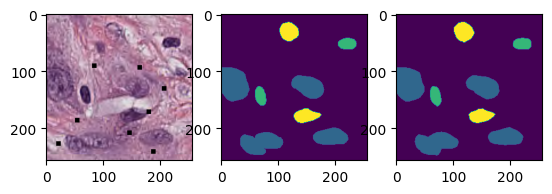

In [82]:
import random
idx = random.randint(0,100)
def visualization_pascalvoc(model, idx):
    model.eval()
    with torch.no_grad():
        x, y = train_dataset.__getitem__(idx) # get x: (C, H , W) , y: (H, W)
#         print(x.shape ,y.shape) # (C, H , W) - > (B, C, H, W) -> model
        x = x.to(device).float().unsqueeze(0) # convert x: (C, H , W) -> (1, C, H, W) vi model need Batch at first
        y = y.to(device).long().unsqueeze(0) # convert x: (C, H , W) -> (1, C, H, W) vi model need Batch at first
        print(y.shape)
        yhat = model(x, y) # input x: (1, C, H, W) and output y: (1, C, H , W)
        print(yhat.shape)
        yhat_mask = yhat.argmax(dim=1) # convert (1, C, H , W) -> (C, H , W)
        print(yhat_mask.shape)
        inv_img_tensor = inverse_norm(x.squeeze()) # x: (1, C, H, W) -> (C, H, W)
#         color_mask_prediction = np.zeros((*yhat_mask.shape,3))
#         for i, color in enumerate(VOC_COLORMAP):
#             color_mask_prediction[yhat_mask.cpu()==i] = np.array(color) # pixel 10(class10) -> [64, 128, 0]
        
#         color_mask_true = np.zeros((*yhat.shape,3))
#         for i, color in enumerate(VOC_COLORMAP):
#             color_mask_true[yhat.cpu()==i] = np.array(color) # pixel 10(class10) -> [64, 128, 0]
        # draw, x, y, yhat_mask
        plt.subplot(1,3,1)
        plt.imshow(inv_img_tensor.permute(1,2,0).cpu())
        plt.subplot(1,3,2)
        plt.imshow(y.squeeze().cpu())
        plt.subplot(1,3,3)
        plt.imshow(yhat_mask.cpu().permute(1,2,0))
        plt.show()
        
visualization_pascalvoc(model, idx)